In [1]:
'''Important Libraries and Modules that would be used throughout the task are imported'''
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import Multiply
from keras.layers import GlobalAveragePooling1D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2MB 12.2MB/s 
     |████████████████████████████████| 2.2MB 13.9MB/s 
     |████████████████████████████████| 3.3MB 31.7MB/s 
     |████████████████████████████████| 870kB 40.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e6d7034f1d9e0b6e3685bf528b5a422b506584546e9e795e24319b057a98430a
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Loading of Data in Pandas DataFrame from CSV file
#Other Features were removed from the CSV as they are not used in the tasks 
data=pd.read_csv("/content/drive/MyDrive/IIIT_MIDAS/flipkart_com-ecommerce_sample.csv", encoding= 'unicode_escape')
print(len(data))
data.head()

20000


,product_category_tree,description,brand
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,AW
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Sicons


In [5]:
data.description[0]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts"

In [6]:
#Text Preprocessing
category=[]
description=[]
for i in range(len(data)):
  if type(data['description'][i]) == str :
    category.append(data["product_category_tree"][i].split('>>')[0][2:-1]) #Primary Category is being extracted from the product category tree
    des = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    des = re.sub('[/(){}\[\]\|@,.;_]', ' ', des) #Removing the symbols that are not useful in classification task
    des = des.lower() #Converting the text into lowercase 
    description.append(des) 

data = pd.DataFrame()
data["category"]=category
data["description"]=description
data.head()    


,category,description
0,Clothing,key features of alisha solid women s cycling s...
1,Furniture,fabhomedecor fabric double sofa bed finish co...
2,Footwear,key features of aw bellies sandals wedges heel...
3,Clothing,key features of alisha solid women s cycling s...
4,Pet Supplies,specifications of sicons all purpose arnica do...


Total No. of Categories : 266


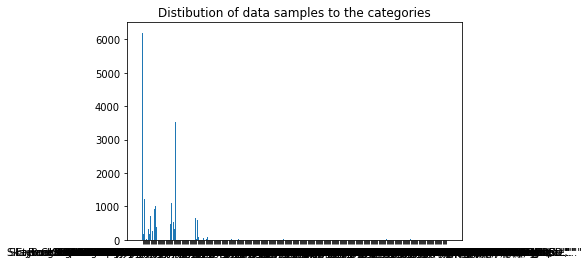

In [7]:
# Distibution of data samples to the categories
category_counts= Counter(category)
print(f"Total No. of Categories :",len(category_counts.keys()))
plt.bar(category_counts.keys(),category_counts.values() )
plt.title(label='Distibution of data samples to the categories')
plt.show() 

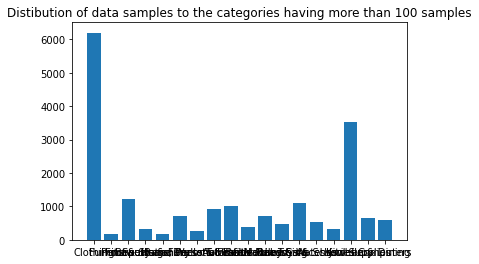

In [8]:
#only keeping the categories with more than 100 samples
new_dict={}
for key, value in category_counts.items():
  if value>100:
    new_dict[key]=value
plt.bar(new_dict.keys(),new_dict.values())
plt.title(label='Distibution of data samples to the categories having more than 100 samples')
plt.show() 

In [9]:
new_dict

{'Automotive': 1012,
 'Baby Care': 483,
 'Bags, Wallets & Belts': 265,
 'Beauty and Personal Care': 710,
 'Clothing': 6197,
 'Computers': 578,
 'Footwear': 1227,
 'Furniture': 180,
 'Home Decor & Festive Needs': 929,
 'Home Furnishing': 699,
 'Jewellery': 3531,
 'Kitchen & Dining': 647,
 'Mobiles & Accessories': 1099,
 'Pens & Stationery': 313,
 'Sports & Fitness': 166,
 'Tools & Hardware': 391,
 'Toys & School Supplies': 330,
 'Watches': 530}

In [10]:
#Storing the description and category having more than 100 instances in dataframe
new_description=[]
new_category=[]
for i in range(len(description)):
  if category[i] in new_dict.keys():
    new_description.append(description[i])
    new_category.append(category[i])
    
new_df=pd.DataFrame()
new_df["description"]=new_description
new_df["category"]=new_category
new_df.head()

,description,category
0,key features of alisha solid women s cycling s...,Clothing
1,fabhomedecor fabric double sofa bed finish co...,Furniture
2,key features of aw bellies sandals wedges heel...,Footwear
3,key features of alisha solid women s cycling s...,Clothing
4,key features of alisha solid women s cycling s...,Clothing


In [11]:
#Encoding the textual label to the integer labels
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(new_df.category)
new_df['categorical_label'] = lab_enc.transform(new_df.category)
new_df.head()

,description,category,categorical_label
0,key features of alisha solid women s cycling s...,Clothing,4
1,fabhomedecor fabric double sofa bed finish co...,Furniture,7
2,key features of aw bellies sandals wedges heel...,Footwear,6
3,key features of alisha solid women s cycling s...,Clothing,4
4,key features of alisha solid women s cycling s...,Clothing,4


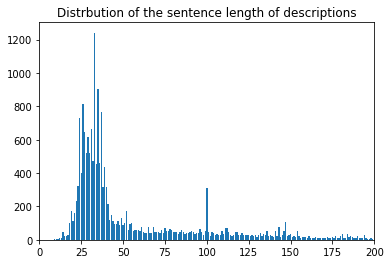

In [12]:
#analysing the sentence length of the description
df=new_df["description"]
length=[]
for i in range(len(df)) :
  if type(df[i])==str:
    length.append(len(nltk.word_tokenize(df[i])))
c= Counter(length)
plt.bar(c.keys(),c.values())
plt.xlim(0,200)
plt.title(label='Distrbution of the sentence length of descriptions')
plt.show() 

In [13]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=18)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#converting input text in the tokens form
sentences = new_df['description']
labels = new_df['categorical_label']
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =128,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#train_test spliting
X_train,X_test,y_train,y_test,mask_train,mask_test=train_test_split(input_ids,labels,attention_masks,test_size=0.3)
X_test,X_val,y_test,y_val,mask_test,mask_val=train_test_split(X_test,y_test,mask_test,test_size=0.5)

In [ ]:
#Compiling the bert model
print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  13842     
Total params: 109,496,082
Trainable params: 109,496,082
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
#Training the bert model
history=bert_model.fit([X_train,mask_train],y_train,batch_size=32,epochs=5,validation_data=([X_val,mask_val],y_val))

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
#Evaluating on test data
y=bert_model.predict([X_test,mask_test])
y_pred = np.argmax(y['logits'],axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.980989
Precision: 0.964730
Recall: 0.946666
F1 score: 0.953215


Text(0.5, 1.0, 'CONFUSION MATRIX - Bert MODEL')

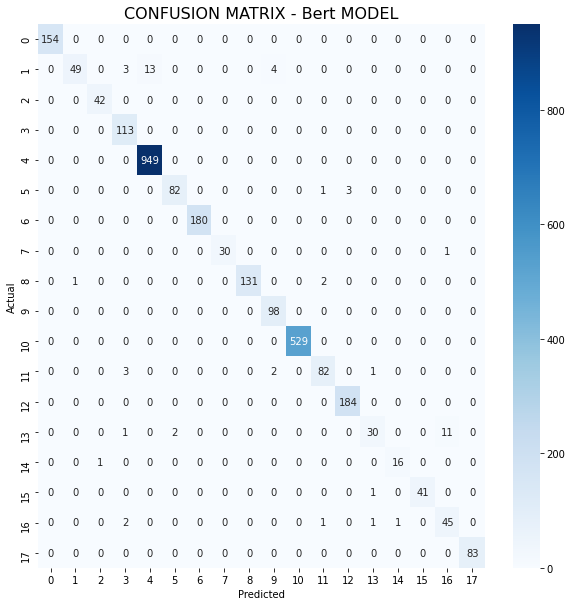

In [ ]:
#plotting the Confusion Matrix
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Bert MODEL", size=16)

In [52]:
#Converting  test labels into one hot vector
labels = sorted(list(set(y_train)))
one_hot = np.zeros((len(labels), len(labels)), int)
np.fill_diagonal(one_hot, 1)
label_dict = dict(zip(labels, one_hot))
y_test = np.eye(len(label_dict))[y_test]

In [60]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test.ravel(), y['logits'].ravel())
roc_auc = auc(fpr, tpr)

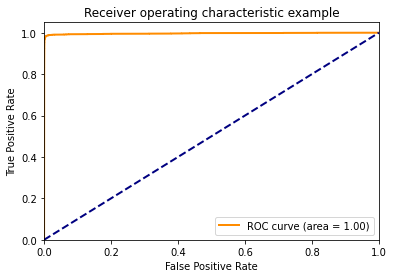

In [61]:
#Plotting ROC curve 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic )
plt.legend(loc="lower right")
plt.show()

In [ ]:
from transformers import *
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
Electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
Electra_model = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator',num_labels=18)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentences = new_df['description']
labels = new_df['categorical_label']
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=Electra_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =128,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
X_train,X_test,y_train,y_test,mask_train,mask_test=train_test_split(input_ids,labels,attention_masks,test_size=0.3)
X_test,X_val,y_test,y_val,mask_test,mask_val=train_test_split(X_test,y_test,mask_test,test_size=0.5)

In [ ]:

print('\nElectra Model',Electra_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

Electra_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
electra (TFElectraMainLayer) multiple                  13483008  
_________________________________________________________________
classifier (TFElectraClassif multiple                  70418     
Total params: 13,553,426
Trainable params: 13,553,426
Non-trainable params: 0
_________________________________________________________________

Electra Model None


In [ ]:
history=Electra_model.fit([X_train,mask_train],y_train,batch_size=32,epochs=5,validation_data=([X_val,mask_val],y_val))


Epoch 1/5
422/422 [==============================] - 79s 186ms/step - loss: 0.1845 - accuracy: 0.9550 - val_loss: 0.1720 - val_accuracy: 0.9623
Epoch 2/5
422/422 [==============================] - 78s 186ms/step - loss: 0.1363 - accuracy: 0.9692 - val_loss: 0.1555 - val_accuracy: 0.9585
Epoch 3/5
422/422 [==============================] - 78s 186ms/step - loss: 0.1008 - accuracy: 0.9787 - val_loss: 0.1298 - val_accuracy: 0.9710
Epoch 4/5
422/422 [==============================] - 78s 186ms/step - loss: 0.0779 - accuracy: 0.9839 - val_loss: 0.1401 - val_accuracy: 0.9696
Epoch 5/5
422/422 [==============================] - 78s 185ms/step - loss: 0.0654 - accuracy: 0.9850 - val_loss: 0.1331 - val_accuracy: 0.9730


In [ ]:
y=Electra_model.predict([X_test,mask_test])
y_pred = np.argmax(y['logits'],axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.977186
Precision: 0.941316
Recall: 0.944786
F1 score: 0.941875


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=18)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentences = new_df['description']
labels = new_df['categorical_label']
input_ids=[]
attention_masks=[]

for sent in sentences:
    roberta_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =128,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(roberta_inp['input_ids'])
    attention_masks.append(roberta_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('\n roberta Model',model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  604434    
Total params: 124,659,474
Trainable params: 124,659,474
Non-trainable params: 0
_________________________________________________________________

 roberta Model None


In [ ]:
print('\n roberta Model',model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
print('Roberta')
y=model.predict([X_test,mask_test])
y_pred = np.argmax(y['logits'],axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

Roberta
Accuracy: 0.979260
Precision: 0.957254
Recall: 0.947210
F1 score: 0.949179


In [37]:
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels = 18)

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
sentences = new_df['description']
labels = new_df['categorical_label']
input_ids=[]
attention_masks=[]

for sent in sentences:
    albert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =128,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(albert_inp['input_ids'])
    attention_masks.append(albert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [40]:
X_train,X_test,y_train,y_test,mask_train,mask_test=train_test_split(input_ids,labels,attention_masks,test_size=0.3)
X_test,X_val,y_test,y_val,mask_test,mask_val=train_test_split(X_test,y_test,mask_test,test_size=0.5)

In [39]:
print('\n albert Model',model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_142 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  13842     
Total params: 11,697,426
Trainable params: 11,697,426
Non-trainable params: 0
_________________________________________________________________

 albert Model None


In [41]:
history=model.fit([X_train,mask_train],y_train,batch_size=32,epochs=5,validation_data=([X_val,mask_val],y_val))


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [42]:
print('ALbert')
y=model.predict([X_test,mask_test])
y_pred = np.argmax(y['logits'],axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

ALbert
Accuracy: 0.971656
Precision: 0.949817
Recall: 0.940752
F1 score: 0.943644
